# User prompt
The user define the research objective a prompt. I use openAI to identify relevant key words for the research.
Documentation:
* https://platform.openai.com/docs/guides/text?api-mode=responses&lang=python

In [ ]:
#  I'm working with a client looking to understand the potential use of silicone based products for soft contact lenses. 

In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI
from openai.types.responses import Response

# Load the API key
load_dotenv()

client: OpenAI = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Research objective
research_objective: str = """
At present, one of our clients is looking to speak with professionals who have insights about the emerging technologies 
in soft contact lens manufacturing, particularly non-injection moulded methods. They would broadly like to understand how 
these technologies are reshaping the industry—from on-demand manufacturing to smart, drug-delivery-enabled lenses.
"""
# TODO: improve the prompt to extract words from the research objective. Problem:output variability
prompt: str = f"""
You are assisting a researcher in generating targeted search terms for academic and patent literature related to the research topic described below.

Return a JSON object with the following structure:
- "main_topic": a concise list with one element of words (2–3 words) extracted from the Research Objective that reflects the core technological focus
- "openalex": exactly 5 academic search terms, extracted from the Research Objective that reflects the client objective
- "patentview": exactly 1 patent-related single keywords, extrapolated from the Research Objective that reflects the general client objective
- "cpc_codes": exactly 5 valid CPC classification codes relevant to the topic

Instructions:
- Output must be valid JSON only — no markdown, comments, or extra text
- All terms in "openalex" and "patentview" must be single or double words
- Do NOT include any words or close variants from "main_topic" in "openalex" or "patentview"
- All terms across the fields must be unique — no repetition or synonyms
- Each term in "openalex" and "patentview" must be conceptually compatible with the "main_topic" so that combining them (e.g. "main_topic" AND "keyword") produces a realistic and meaningful research query
- Use language and terminology commonly found in scientific publications and patent documents

Research Objective:
\"\"\" 
{research_objective} 
\"\"\"
"""

# Availables models: https://platform.openai.com/docs/pricing
GPT_MODEL = "gpt-4o-mini"

response: Response = client.responses.create(

    model=GPT_MODEL,
    input = prompt
)

print(f"The lenght of research objective is: {len(research_objective)}")

# print(type(response))
print(response.output_text)

The lenght of research objective is: 360
{
  "main_topic": ["soft contact lenses"],
  "openalex": ["on-demand manufacturing", "smart lenses", "drug delivery", "emerging technologies", "non-moulded methods"],
  "patentview": "manufacturing",
  "cpc_codes": ["A61F2/00", "B29C45/00", "B29C33/00", "A61F2/60", "G02C7/00"]
}


In [5]:
import json

# Print the main topic
research_key_words: list[str]= json.loads(response.output_text)
print(research_key_words["main_topic"])
# print(research_key_words["openalex"][0])

['soft contact lenses']


# Openalex API
https://docs.openalex.org/

OpenAlex API: Valid Parameters

Pagination & Navigation
- `cursor`
- `page`
- `per_page`, `per-page`

Filtering & Searching
- `filter`
- `search`
- `q`
- `sample`
- `seed`

Grouping & Aggregation
- `group_by`, `group-by`
- `group_bys`, `group-bys`

Sorting & Selection
- `sort`
- `select`

Metrics
- `apc_sum`
- `cited_by_count_sum`

Other
- `mailto`
- `format`
- `warm`


## Loading papers

### Config & Constants

In [ ]:
# Openalex parameters
OPENALEX_URL = "https://api.openalex.org/works"
MAILTO = "adyl.elguamra@gmail.com"
PER_PAGE = 25
PAGE = 1

### Basic research query

In [6]:
import requests
import pandas as pd
import time

keywords = research_key_words["openalex"]
OPENALEX_URL = "https://api.openalex.org/works"

def query_openalex(keyword, per_page=50):
    params = {
        "search": f"contact lens {keyword}",
        "per_page": per_page,
        "sort": "relevance_score:desc",
        "mailto": "adyl.elguamra@gmail.com"
    }
    
    try:
        response = requests.get(OPENALEX_URL, params=params, timeout=10)
        print("Request URL:", response.url)  
        
        response.raise_for_status()
        data = response.json()
        return data.get("results", [])
    
    except requests.exceptions.RequestException as e:
        print(f"Error for keyword '{keyword}': {e}")
        return []

dfs = []

for kw in keywords:
    print(f"\n Searching for keyword: {kw}")
    results = query_openalex(keyword=kw, per_page = PER_PAGE)
    
    if results:
        df = pd.DataFrame(results)
        df['keyword'] = kw     
        dfs.append(df)

    
    time.sleep(1)

if dfs:
    openalex_raw_df = pd.concat(dfs, ignore_index=True)
    print("Final dataframe shape:", openalex_raw_df.shape)
else:
    print("No results found.")


 Searching for keyword: on-demand manufacturing
Request URL: https://api.openalex.org/works?search=contact+lens+on-demand+manufacturing&per_page=25&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com

 Searching for keyword: smart lenses
Request URL: https://api.openalex.org/works?search=contact+lens+smart+lenses&per_page=25&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com

 Searching for keyword: drug delivery
Request URL: https://api.openalex.org/works?search=contact+lens+drug+delivery&per_page=25&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com

 Searching for keyword: emerging technologies
Request URL: https://api.openalex.org/works?search=contact+lens+emerging+technologies&per_page=25&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com

 Searching for keyword: non-moulded methods
Request URL: https://api.openalex.org/works?search=contact+lens+non-moulded+methods&per_page=25&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Fina

### Fitler relevant data

In [7]:
print(openalex_raw_df.columns.tolist())

openalex_columns_to_keep = ["keyword","title", "publication_date", "authorships", "abstract_inverted_index"]

openalex_subset_df = openalex_raw_df[openalex_columns_to_keep].copy()

openalex_subset_df.head()

['id', 'doi', 'title', 'display_name', 'relevance_score', 'publication_year', 'publication_date', 'ids', 'language', 'primary_location', 'type', 'type_crossref', 'indexed_in', 'open_access', 'authorships', 'institution_assertions', 'countries_distinct_count', 'institutions_distinct_count', 'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list', 'apc_paid', 'fwci', 'has_fulltext', 'cited_by_count', 'citation_normalized_percentile', 'cited_by_percentile_year', 'biblio', 'is_retracted', 'is_paratext', 'primary_topic', 'topics', 'keywords', 'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location', 'sustainable_development_goals', 'grants', 'datasets', 'versions', 'referenced_works_count', 'referenced_works', 'related_works', 'abstract_inverted_index', 'abstract_inverted_index_v3', 'cited_by_api_url', 'counts_by_year', 'updated_date', 'created_date', 'fulltext_origin', 'keyword']


keyword                                              title  \
0  on-demand manufacturing  Contact Lens Materials: A Materials Science Pe...   
1  on-demand manufacturing  Architectural Innovation: The Reconfiguration ...   
2  on-demand manufacturing  The Economics of Organization: The Transaction...   
3  on-demand manufacturing  Tribo-electric Charging in the Ultra-high Prec...   
4  on-demand manufacturing  Biomedical applications of hydrogels: A review...   

  publication_date                                        authorships  \
0       2019-01-14  [{'author_position': 'first', 'author': {'id':...   
1       1990-03-01  [{'author_position': 'first', 'author': {'id':...   
2       1981-11-01  [{'author_position': 'first', 'author': {'id':...   
3       2014-01-01  [{'author_position': 'first', 'author': {'id':...   
4       2014-11-29  [{'author_position': 'first', 'author': {'id':...   

                             abstract_inverted_index  
0  {'More': [0], 'is': [1, 28], 'demanded': [2], ...  
1  {'ThP': [0], 'tiaditinn-Tl': [1], 'catPgori': ...  
2  {'The': [0, 64, 92], 'transaction': [1, 12, 25...  
3  {'The': [0, 123], 'manufacture': [1], 'of': [2...  
4  {'Hydrogels': [0], 'have': [1], 'become': [2],...

### Data extraction logic

In [ ]:
# TODO: how to deal with missing values?
# Extract author_display_name
openalex_subset_df.loc[:, 'author_display_name'] = openalex_subset_df['authorships'].apply(
    lambda x: x[0]['author']['display_name'] if isinstance(x, list) and x else None
)
# Extract institutions name
openalex_subset_df.loc[:, 'institution_display_name'] = openalex_subset_df['authorships'].apply(
    lambda x: x[0]['institutions'][0]['display_name'] if x[0]['institutions'] else None 
)

# Extract country code
openalex_subset_df.loc[:, 'institution_country_code'] = openalex_subset_df['authorships'].apply(
    lambda x: x[0]['institutions'][0]['country_code'] if isinstance(x[0]['institutions'], list) and x[0]['institutions'] else None
)

openalex_subset_df.head()

keyword                                              title  \
0  on-demand manufacturing  Contact Lens Materials: A Materials Science Pe...   
1  on-demand manufacturing  Architectural Innovation: The Reconfiguration ...   
2  on-demand manufacturing  The Economics of Organization: The Transaction...   
3  on-demand manufacturing  Tribo-electric Charging in the Ultra-high Prec...   
4  on-demand manufacturing  Biomedical applications of hydrogels: A review...   

  publication_date                                        authorships  \
0       2019-01-14  [{'author_position': 'first', 'author': {'id':...   
1       1990-03-01  [{'author_position': 'first', 'author': {'id':...   
2       1981-11-01  [{'author_position': 'first', 'author': {'id':...   
3       2014-01-01  [{'author_position': 'first', 'author': {'id':...   
4       2014-11-29  [{'author_position': 'first', 'author': {'id':...   

                             abstract_inverted_index  \
0  {'More': [0], 'is': [1, 28], 'demanded': [2], ...   
1  {'ThP': [0], 'tiaditinn-Tl': [1], 'catPgori': ...   
2  {'The': [0, 64, 92], 'transaction': [1, 12, 25...   
3  {'The': [0, 123], 'manufacture': [1], 'of': [2...   
4  {'Hydrogels': [0], 'have': [1], 'become': [2],...   

          author_display_name   institution_display_name  \
0  Christopher S. A. Musgrave  University College Dublin   
1           Rebecca Henderson                       None   
2        Oliver E. Williamson                       None   
3          Oluwole A. Olufayo  Nelson Mandela University   
4                 Enrica Caló      University of Reading   

  institution_country_code  
0                       IE  
1                     None  
2                     None  
3                       ZA  
4                       GB

### Abstract utility

In [11]:
def reconstruct_abstract(abstract_inverted_index: dict[str, list[int]]) -> str:
    '''
    Reconstruct the abstract from abstract_inverted_index
    '''
    
    # Some works don't have an abstract
    if not abstract_inverted_index:
        return ""
        
    # Variable to store the highest index
    max_value: int = 0
     # Loop through all the list of position in the abstract_inverted_index dictionary.
    for values in abstract_inverted_index.values():
        # Loop through all the index value
        for value in values:
            # identify the highest value index
            if value >= max_value:
                max_value = value
                
    # Create an empty list with abstract size        
    abstract: list[str] = [None] * (max_value +1)

    # Loop through each word in the abstract_inverted_index:
    for word, positions in abstract_inverted_index.items():
        # For each word, get the list of positions it appears in.
        for position in positions:
            # Insert each word into its correct position in the list.
            abstract[position]= word
                        
    # Join all the words in the list into a single string, separated by spaces.
    # abstract_text: str = " ".join(abstract)
    abstract_text: str = " ".join(word if word is not None else "" for word in abstract)

    # print("\n", abstract_text)
    
    return abstract_text

# Extract abstract
# Apply your reconstruct_abstract function
print("Abtract extration started...")
openalex_subset_df.loc[:, 'abstract'] = openalex_subset_df['abstract_inverted_index'].apply(
    reconstruct_abstract
)
print("Abtract extration complete.")

Abtract extration started...
Abtract extration complete.


In [13]:
# Openalex final dataframe
openalex_df = openalex_subset_df[['keyword', 
                                  'title',
                                  'abstract',
                                  'publication_date', 
                                  'author_display_name', 
                                  'institution_display_name', 
                                  'institution_country_code' 
                                  ]].copy()

print(openalex_df.shape)
openalex_df.head()

(125, 7)


keyword                                              title  \
0  on-demand manufacturing  Contact Lens Materials: A Materials Science Pe...   
1  on-demand manufacturing  Architectural Innovation: The Reconfiguration ...   
2  on-demand manufacturing  The Economics of Organization: The Transaction...   
3  on-demand manufacturing  Tribo-electric Charging in the Ultra-high Prec...   
4  on-demand manufacturing  Biomedical applications of hydrogels: A review...   

                                            abstract publication_date  \
0  More is demanded from ophthalmic treatments us...       2019-01-14   
1  ThP tiaditinn-Tl catPgori ?:ation nf innovatio...       1990-03-01   
2  The transaction cost approach to the study of ...       1981-11-01   
3  The manufacture of precision optics with diver...       2014-01-01   
4  Hydrogels have become very popular due to thei...       2014-11-29   

          author_display_name   institution_display_name  \
0  Christopher S. A. Musgrave  University College Dublin   
1           Rebecca Henderson                       None   
2        Oliver E. Williamson                       None   
3          Oluwole A. Olufayo  Nelson Mandela University   
4                 Enrica Caló      University of Reading   

  institution_country_code  
0                       IE  
1                     None  
2                     None  
3                       ZA  
4                       GB

## Identify relevant papers

Documentation:
* https://python.langchain.com/docs/tutorials/rag/#overview 
* https://scalexi.medium.com/implementing-a-retrieval-augmented-generation-rag-system-with-openais-api-using-langchain-ab39b60b4d9f
* https://platform.openai.com/docs/guides/embeddings
* https://python.langchain.com/docs/tutorials/retrievers/
* https://cookbook.openai.com/examples/get_embeddings_from_dataset

In [16]:
# Create a new column: will inform if the paper is relevant or not
openalex_df["relevant"] = ""
# Create a new column: will provide the relevance justification
openalex_df["justification"] = ""
# print the shape
print("Dataframe shape:",openalex_df.shape)
# Print first rows of dataframe
openalex_df[["title", "publication_date", "institution_country_code", "institution_display_name"]].head()


Dataframe shape: (125, 9)


title publication_date  \
0  Contact Lens Materials: A Materials Science Pe...       2019-01-14   
1  Architectural Innovation: The Reconfiguration ...       1990-03-01   
2  The Economics of Organization: The Transaction...       1981-11-01   
3  Tribo-electric Charging in the Ultra-high Prec...       2014-01-01   
4  Biomedical applications of hydrogels: A review...       2014-11-29   

  institution_country_code   institution_display_name  
0                       IE  University College Dublin  
1                     None                       None  
2                     None                       None  
3                       ZA  Nelson Mandela University  
4                       GB      University of Reading

In [17]:
import pandas as pd

def get_justification(title, abstract, objective):
    prompt = f"""
    You are the CEO, as well as a scientific and regulatory analyst, evaluating academic research for a company .

    Below is a paper's title and abstract, followed by the company's research objective. 
    
    Title:  
    {title}

    Abstract:  
    {abstract}

    Research Objective:  
    {objective}

    Assess if the paper is relevant. Start the answer with Yes or No, followed by a 1–2 sentence explanation based only on the title and abstract. 
    Be concise, specific, and fact-based. Avoid speculation or vague generalizations.
    """

    # print("Generating GPT justifications...")
    
    try:
        response: Response = client.responses.create(
        model=GPT_MODEL,
        input = prompt
        )
        return response.output_text
    except Exception as e:
        return f"ERROR: {e}"
    
def process_row(row: pd.Series) -> pd.Series:
    output = get_justification(row["title"], row["abstract"], research_objective)
    output_lower = output.lower()
    
    if output_lower.startswith("yes"):
        relevant = "yes"
    elif output_lower.startswith("no"):
        relevant = "no"
    else:
        relevant = "unclear"
        
    return pd.Series({"relevant": relevant, "justification": output})

# Apply the function to the entire DataFrame
openalex_df[["relevant", "justification"]] = openalex_df.apply(process_row, axis=1)

In [20]:
# Show full column contents and more columns
#pd.set_option("display.max_colwidth", None)    # Show full text in cells
print("The dataframe shape of all papers:", openalex_df.shape)
print("The dataframe shape of relevant papers:", openalex_df[openalex_df["relevant"]=="yes"].shape)
openalex_df[openalex_df["relevant"]=="yes"][["keyword","title","institution_country_code", "institution_display_name", "publication_date", "justification"]].head()

The dataframe shape of all papers: (125, 9)
The dataframe shape of relevant papers: (69, 9)


keyword  \
0   on-demand manufacturing   
3   on-demand manufacturing   
4   on-demand manufacturing   
10  on-demand manufacturing   
13  on-demand manufacturing   

                                                title  \
0   Contact Lens Materials: A Materials Science Pe...   
3   Tribo-electric Charging in the Ultra-high Prec...   
4   Biomedical applications of hydrogels: A review...   
10  Analysis on multifocal contact lens design bas...   
13  Active Optical Beam Shaping Based on Liquid Cr...   

   institution_country_code  \
0                        IE   
3                        ZA   
4                        GB   
10                       TW   
13                       CN   

                             institution_display_name publication_date  \
0                           University College Dublin       2019-01-14   
3                           Nelson Mandela University       2014-01-01   
4                               University of Reading       2014-11-29   
10  National Taiwan University of Science and Tech...       2017-09-28   
13                                  Tongji University       2020-10-29   

                                        justification  
0   Yes, the paper is relevant as it discusses adv...  
3   Yes, the paper is relevant as it discusses ult...  
4   Yes, the paper is relevant as it discusses hyd...  
10  Yes, the paper is relevant as it discusses the...  
13  Yes, the paper is relevant as it discusses adv...

## Openalex: trends in relevant papers
* Track the number of papers per year — increasing output indicates a growing area.
* Frequent authors or groups often signal thought leadership.
* Which countries, universities, or labs are publishing the most?
* Are there regional clusters or shifts in research activity?



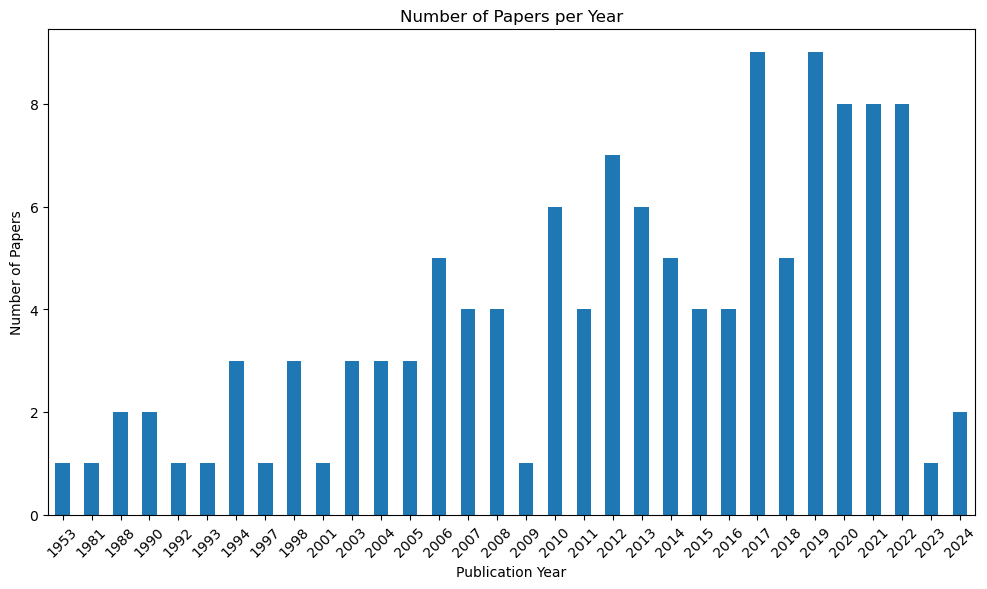

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe structure
# Assuming you already have your dataframe as openalex_df

# Convert publication_date to datetime
openalex_df['publication_date'] = pd.to_datetime(openalex_df['publication_date'], errors='coerce')

# Extract year
openalex_df['publication_year'] = openalex_df['publication_date'].dt.year

# Group by year and count number of papers
papers_per_year = openalex_df.groupby('publication_year').size()

# Plot
plt.figure(figsize=(10, 6))
papers_per_year.plot(kind='bar')
plt.xlabel("Publication Year")
plt.ylabel("Number of Papers")
plt.title("Number of Papers per Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


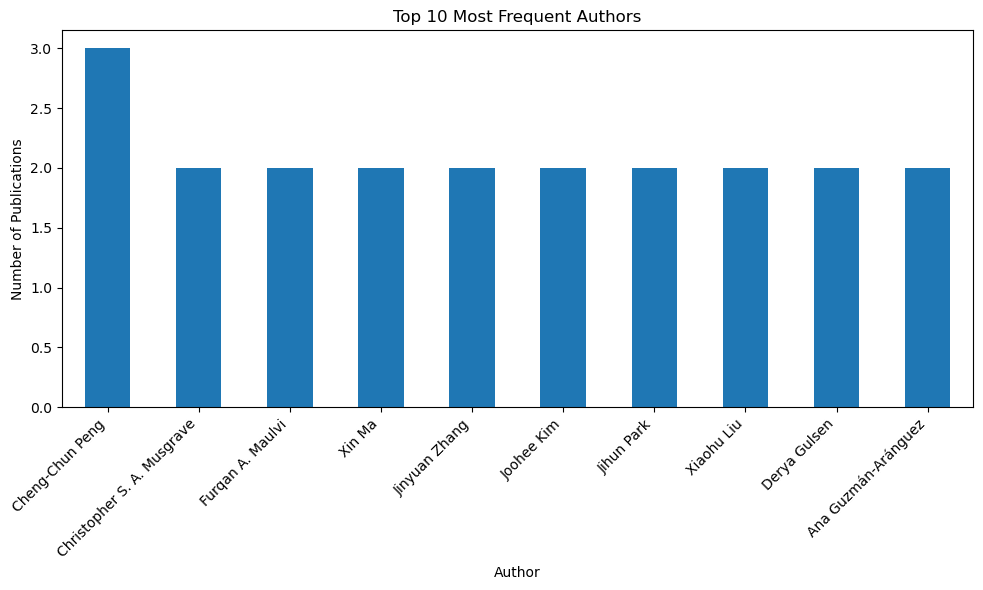

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# First, count author frequencies
# (assuming openalex_df already has 'author_display_name' column)
author_counts = openalex_df['author_display_name'].value_counts()

# Get top 10 most frequent authors
top_authors = author_counts.head(10)

# Plot
plt.figure(figsize=(10, 6))
top_authors.plot(kind='bar')
plt.xlabel("Author")
plt.ylabel("Number of Publications")
plt.title("Top 10 Most Frequent Authors")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


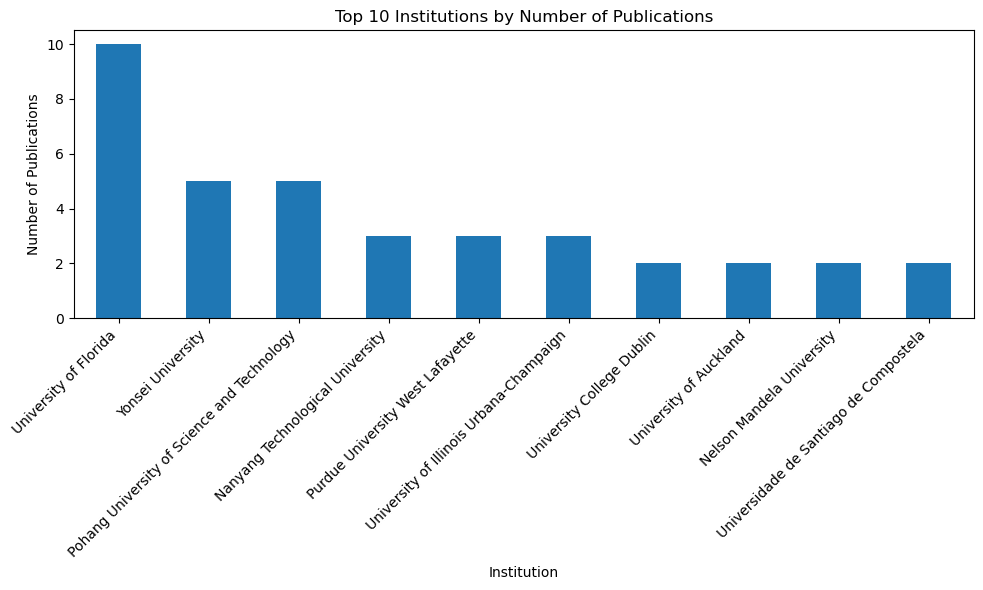

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe has 'institution_display_name' column
# Count institutions
institution_counts = openalex_df['institution_display_name'].value_counts()

# Get top 10 institutions
top_institutions = institution_counts.head(10)

# Plot
plt.figure(figsize=(10, 6))
top_institutions.plot(kind='bar')
plt.xlabel("Institution")
plt.ylabel("Number of Publications")
plt.title("Top 10 Institutions by Number of Publications")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

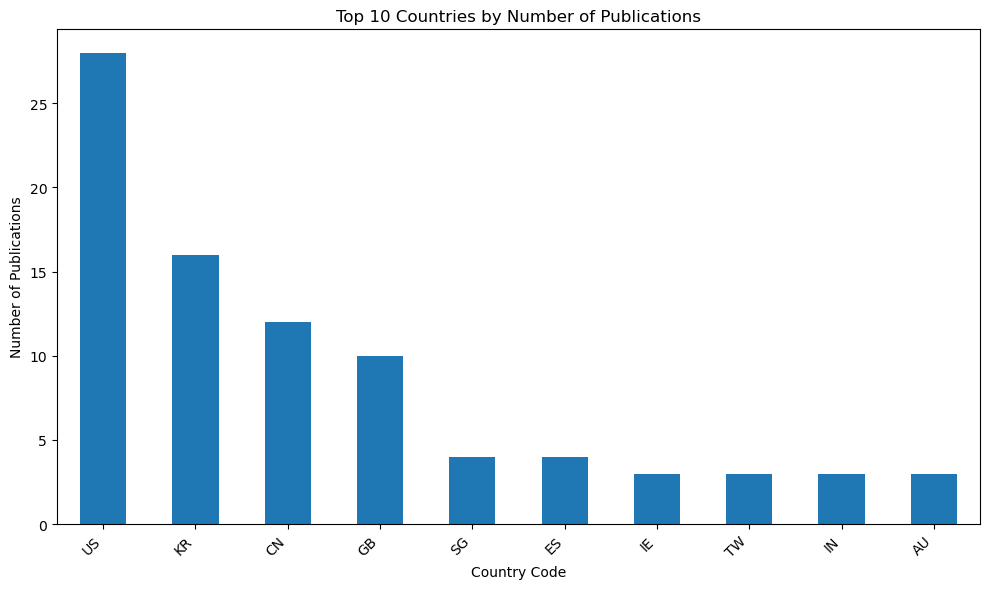

In [25]:
# Similarly
country_counts = openalex_df['institution_country_code'].value_counts()
top_countries = country_counts.head(10)

plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar')
plt.xlabel("Country Code")
plt.ylabel("Number of Publications")
plt.title("Top 10 Countries by Number of Publications")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
oa_trends_df = openalex_df[openalex_df["relevant"]=="yes"].copy()
oa_trends_df[["keyword","title","institution_country_code", "institution_display_name", "publication_date", "justification"]].head()

keyword  \
0   on-demand manufacturing   
3   on-demand manufacturing   
4   on-demand manufacturing   
10  on-demand manufacturing   
13  on-demand manufacturing   

                                                title  \
0   Contact Lens Materials: A Materials Science Pe...   
3   Tribo-electric Charging in the Ultra-high Prec...   
4   Biomedical applications of hydrogels: A review...   
10  Analysis on multifocal contact lens design bas...   
13  Active Optical Beam Shaping Based on Liquid Cr...   

   institution_country_code  \
0                        IE   
3                        ZA   
4                        GB   
10                       TW   
13                       CN   

                             institution_display_name publication_date  \
0                           University College Dublin       2019-01-14   
3                           Nelson Mandela University       2014-01-01   
4                               University of Reading       2014-11-29   
10  National Taiwan University of Science and Tech...       2017-09-28   
13                                  Tongji University       2020-10-29   

                                        justification  
0   Yes, the paper is relevant as it discusses adv...  
3   Yes, the paper is relevant as it discusses ult...  
4   Yes, the paper is relevant as it discusses hyd...  
10  Yes, the paper is relevant as it discusses the...  
13  Yes, the paper is relevant as it discusses adv...

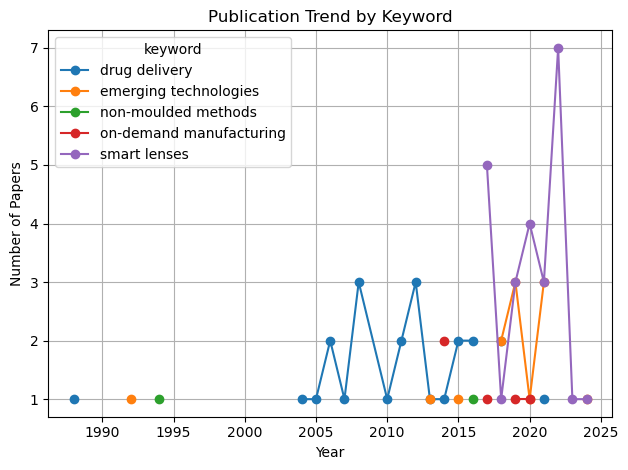

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

oa_trends_df['year'] = pd.to_datetime(oa_trends_df['publication_date']).dt.year

oa_trends_df.groupby(['year', 'keyword']).size().unstack().plot(
    kind='line',
    marker='o',
    title='Publication Trend by Keyword'
)
plt.ylabel('Number of Papers')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

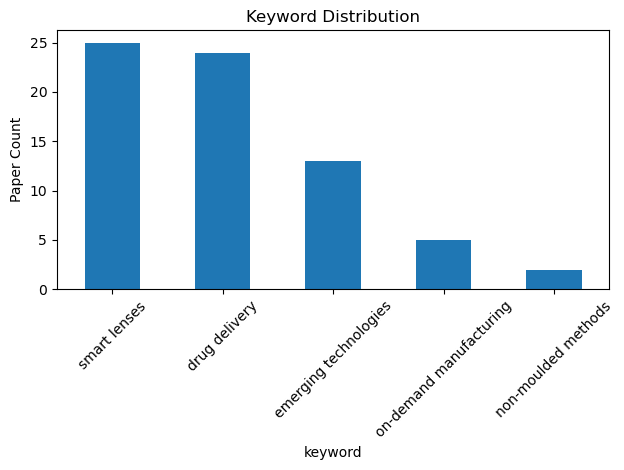

In [28]:
oa_trends_df['keyword'].value_counts().plot(
    kind='bar',
    title='Keyword Distribution',
    ylabel='Paper Count'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


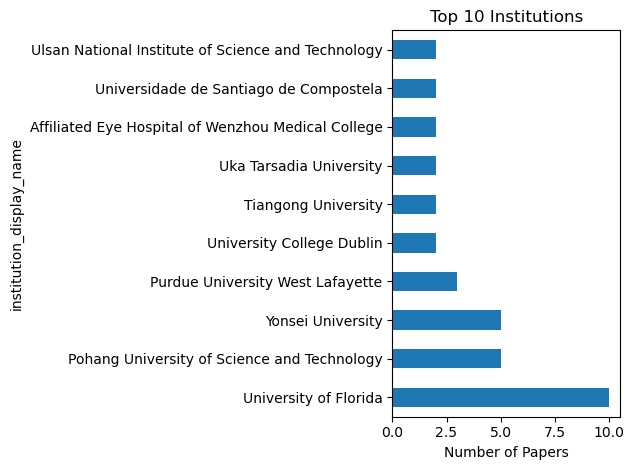

In [29]:
oa_trends_df['institution_display_name'].value_counts().head(10).plot(
    kind='barh',
    title='Top 10 Institutions',
    xlabel='Number of Papers'
)
plt.tight_layout()
plt.show()


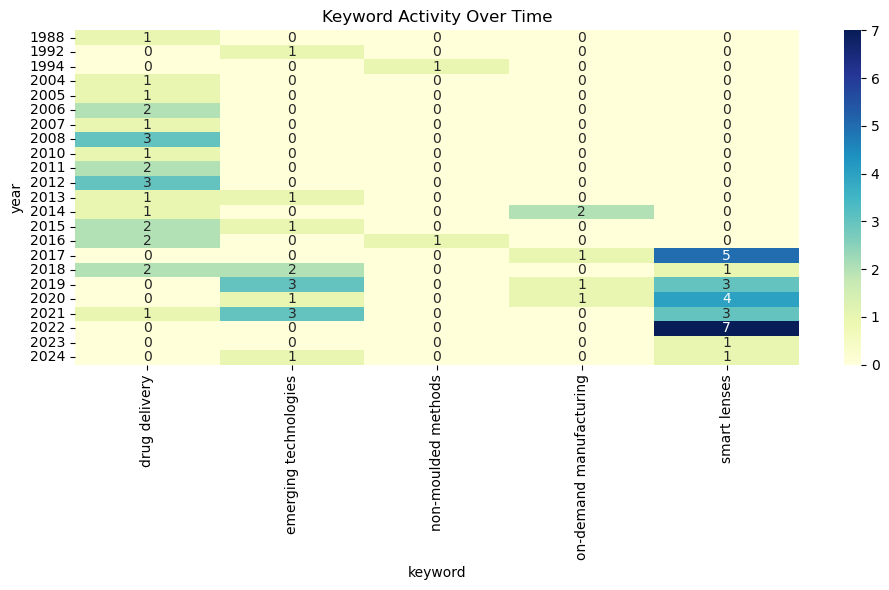

In [30]:
import seaborn as sns

heatmap_data = (
    oa_trends_df.groupby(['year', 'keyword'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Keyword Activity Over Time")
plt.tight_layout()
plt.show()


# Patentview API
https://patentsview.org/apis/purpose
The current version of the new PatentSearch API delivers data on patents granted through March 31, 2025.

https://github.com/PatentsView/PatentsView-Code-Examples/tree/main

https://github.com/PatentsView/PatentsView-Code-Examples/blob/main/data-downloads/0-getting-started.ipynb

## Loading data

### Config and constants

In [31]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os

# Load API key
load_dotenv()
PATENTVIEW_API_KEY = os.getenv("PATENTSVIEW_API_KEY")


# Endpoint and headers
PATENTVIEW_URL = "https://search.patentsview.org/api/v1/patent" # url = "https://search.patentsview.org/api/v1/patent"
HEADERS = {
    "X-Api-Key": PATENTVIEW_API_KEY,
    "Content-Type": "application/json"
}


### Test simple query
https://search.patentsview.org/swagger-ui/

In [32]:
import requests
import json

patentview_params = {
    "q": '''
        {
            "_and": [
                {"_text_phrase": {"patent_title": "contact lens"}},
                {"_text_phrase": {"patent_title": "contact lens"}}
            ]
        }
    ''',
    "f": '["patent_id", "patent_title", "patent_date", "patent_abstract", "applicants", "application", "assignees", "attorneys", "cpc_current"]', # https://search.patentsview.org/docs/docs/Search%20API/EndpointDictionary
    "o": '{"size": 500, "exclude_withdrawn": true}',
    "s": '[{"patent_date": "desc"}]'
}

response = requests.get(PATENTVIEW_URL, headers=HEADERS, params=patentview_params)
# print(re§sponse.json())

data = response.json()


# Pretty-print the JSON data
print(json.dumps(data, indent=4))

{
    "error": false,
    "count": 500,
    "total_hits": 2192,
    "patents": [
        {
            "patent_id": "12245816",
            "patent_title": "Intraocular pressure monitoring contact lens",
            "patent_date": "2025-03-11",
            "patent_abstract": "A device for non-invasive monitoring and measuring of intraocular pressure (IOP) of a subject includes a flexible lens that fits on the eye and changes curvature in response to a change in curvature of the eye. A microchannel disposed in or on the lens has one or more ends that are open to the atmosphere and an indicator solution is disposed in a portion of the 5 microchannel. The microchannel exhibits a change in volume in response to a change in curvature of the lens, which results in a change in position of the indicator solution in the microchannel. The change in position of the indicator solution in the microchannel is indicative of a change in IOP. The change in position of the indicator solution may be dete

In [33]:
# Extract results into DataFrame
if "patents" in data:
    patentview_df = pd.DataFrame(data["patents"])
    patentview_df["applicant_organization"]= patentview_df["applicants"].apply(lambda x: x[0]["applicant_organization"] if isinstance(x, list) else None) # truthy
    print(patentview_df[["patent_title","patent_date", "applicants","applicant_organization"]].head())
else: 
    print("No results found or unexpected response format.")

                                        patent_title patent_date  \
0       Intraocular pressure monitoring contact lens  2025-03-11   
1  Preservative-free contact lens treating soluti...  2025-03-04   
2  Material for manufacturing contact lenses and ...  2025-03-04   
3               Rotationally stabilized contact lens  2025-03-04   
4  Contact lens for automatically aiming in the d...  2025-02-25   

                                          applicants  \
0  [{'applicant_name_first': None, 'applicant_nam...   
1  [{'applicant_name_first': None, 'applicant_nam...   
2  [{'applicant_name_first': None, 'applicant_nam...   
3  [{'applicant_name_first': None, 'applicant_nam...   
4  [{'applicant_name_first': None, 'applicant_nam...   

           applicant_organization  
0  Queen's University at Kingston  
1   Bausch + Lomb Ireland Limited  
2               INNO VISION CORP.  
3           OneFocus Vision, Inc.  
4          INSTITUT MINES TELECOM  


In [35]:
print(patentview_df.columns.tolist())

['patent_id', 'patent_title', 'patent_date', 'patent_abstract', 'application', 'applicants', 'assignees', 'attorneys', 'cpc_current', 'applicant_organization']


In [36]:
patentview_df[["patent_id", "patent_title", "patent_date", 'applicants']].head()

patent_id                                       patent_title patent_date  \
0  12245816       Intraocular pressure monitoring contact lens  2025-03-11   
1  12239658  Preservative-free contact lens treating soluti...  2025-03-04   
2  12240949  Material for manufacturing contact lenses and ...  2025-03-04   
3  12242139               Rotationally stabilized contact lens  2025-03-04   
4  12235441  Contact lens for automatically aiming in the d...  2025-02-25   

                                          applicants  
0  [{'applicant_name_first': None, 'applicant_nam...  
1  [{'applicant_name_first': None, 'applicant_nam...  
2  [{'applicant_name_first': None, 'applicant_nam...  
3  [{'applicant_name_first': None, 'applicant_nam...  
4  [{'applicant_name_first': None, 'applicant_nam...

### Data Extraction Logic

In [37]:
# Extract applicant_organization
patentview_df.loc[:, 'applicant_organization'] = patentview_df['applicants'].apply(
    lambda x: x[0]['applicant_organization'] if isinstance(x, list) and x else None
)
# Extract first assignee_country
patentview_df.loc[:, 'assignee_country'] = patentview_df['assignees'].apply(
    lambda x: x[0]['assignee_country'] if isinstance(x, list) and x else None
)

# Extract cpc_group_id
patentview_df.loc[:, 'cpc_group_id'] = patentview_df['cpc_current'].apply(
    lambda x: x[0]['cpc_group_id'] if isinstance(x, list) and x else None
)



patentview_df[["patent_id", "patent_title", "patent_date", "applicant_organization", "assignee_country","cpc_group_id"]].head()

patent_id                                       patent_title patent_date  \
0  12245816       Intraocular pressure monitoring contact lens  2025-03-11   
1  12239658  Preservative-free contact lens treating soluti...  2025-03-04   
2  12240949  Material for manufacturing contact lenses and ...  2025-03-04   
3  12242139               Rotationally stabilized contact lens  2025-03-04   
4  12235441  Contact lens for automatically aiming in the d...  2025-02-25   

           applicant_organization assignee_country cpc_group_id  
0  Queen's University at Kingston               CA     A61B3/16  
1   Bausch + Lomb Ireland Limited               IE   A61K31/728  
2               INNO VISION CORP.               TW    C08G77/18  
3           OneFocus Vision, Inc.               US    G02C7/048  
4          INSTITUT MINES TELECOM               FR  G02B27/0093

## Patents trends
* Identify major companies and institutions in the space
* Decide on a range (e.g., last 10 years) to track trends over time.
* number of filings per year to see if interest is growing, stable, or declining.
* Who is filing the most patents?
* Are new entrants emerging?
* Time series of patent volumes
* Heat maps by geography
* cluster by cpc
* attorney id

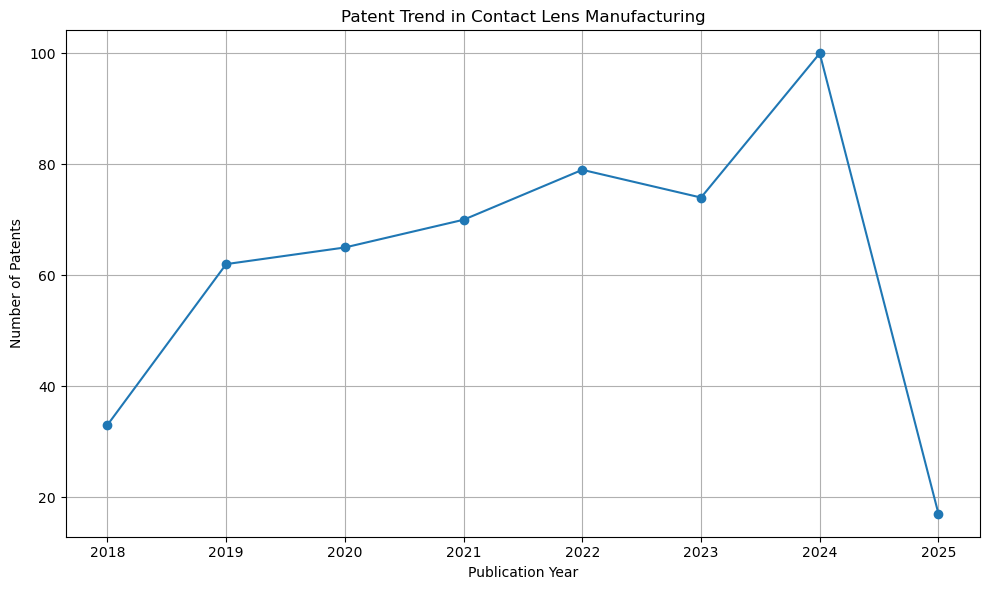

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert patent_date to datetime
patentview_df['patent_date'] = pd.to_datetime(patentview_df['patent_date'], errors='coerce')

# Extract publication year
patentview_df['publication_year'] = patentview_df['patent_date'].dt.year

# Group by year and count number of patents
patents_per_year = patentview_df.groupby('publication_year').size()

# Plot trend
plt.figure(figsize=(10, 6))
patents_per_year.plot(marker='o')
plt.xlabel("Publication Year")
plt.ylabel("Number of Patents")
plt.title("Patent Trend in Contact Lens Manufacturing")
plt.grid(True)
plt.tight_layout()
plt.show()

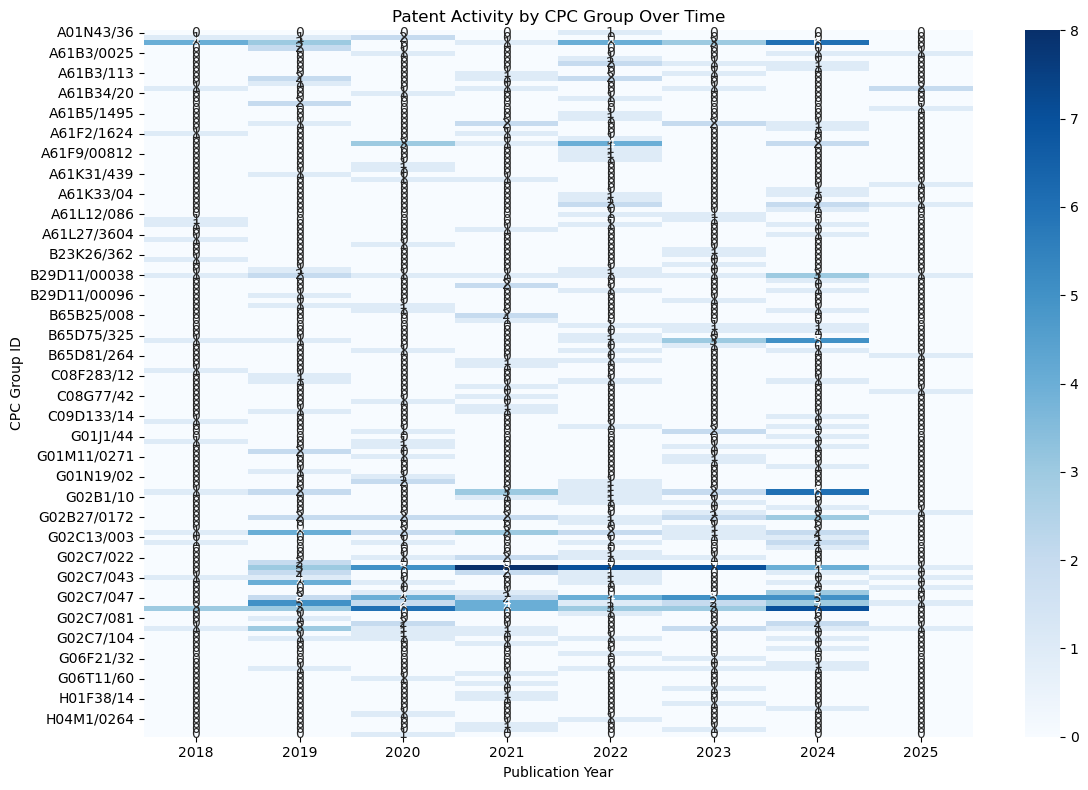

In [39]:
import seaborn as sns

# Group by year and CPC group ID
cpc_year_counts = patentview_df.groupby(['publication_year', 'cpc_group_id']).size().reset_index(name='count')

# Pivot for heatmap
cpc_pivot = cpc_year_counts.pivot(index='cpc_group_id', columns='publication_year', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(cpc_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Patent Activity by CPC Group Over Time")
plt.xlabel("Publication Year")
plt.ylabel("CPC Group ID")
plt.tight_layout()
plt.show()

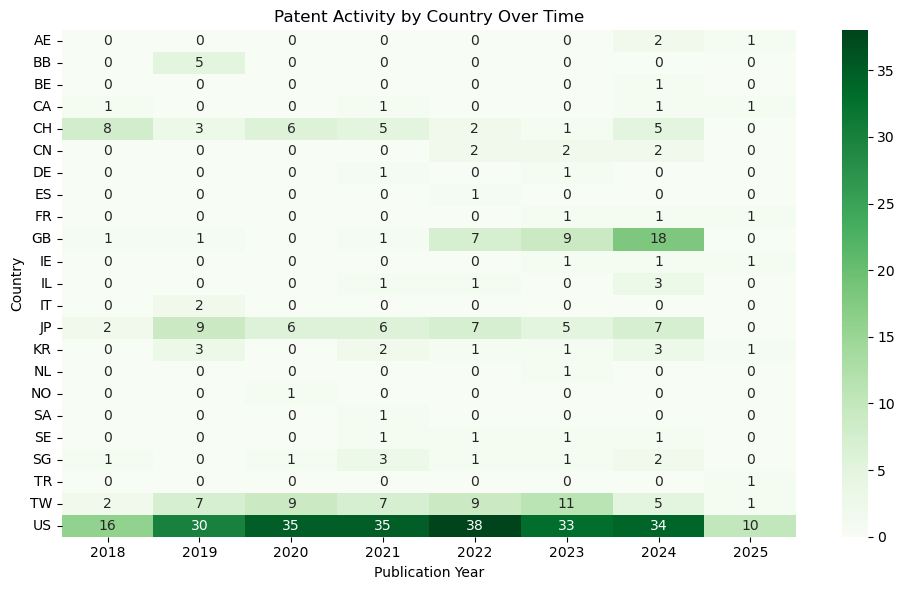

In [40]:
# Group by year and country
country_year_counts = patentview_df.groupby(['publication_year', 'assignee_country']).size().reset_index(name='count')

# Pivot for heatmap
country_pivot = country_year_counts.pivot(index='assignee_country', columns='publication_year', values='count').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(country_pivot, cmap="Greens", annot=True, fmt=".0f")
plt.title("Patent Activity by Country Over Time")
plt.xlabel("Publication Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [ ]:
# # Analysis plan for Contact Lens Manufacturing in plain text

# # 1️⃣ Which companies or organizations are publishing research on contact lens manufacturing?
# # - Use the 'institution_display_name' column to count organizations.
# institution_counts = openalex_df['institution_display_name'].value_counts().head(10)

# # 2️⃣ Which countries are most active in contact lens manufacturing research?
# # - Use 'institution_country_code' column to count country activity.
# country_counts = openalex_df['institution_country_code'].value_counts().head(10)

# # 3️⃣ What are the most common emerging technologies discussed in these papers?
# # - If you have 'concepts' or 'keywords' columns, count occurrences.
# # - Otherwise, you can parse titles or abstracts for keywords.
# # Example:
# # keywords_counts = openalex_df['concepts'].explode().value_counts().head(10)

# # 4️⃣ How has publication activity changed over time?
# # - Extract 'publication_year' from 'publication_date' and count per year.
# openalex_df['publication_date'] = pd.to_datetime(openalex_df['publication_date'], errors='coerce')
# openalex_df['publication_year'] = openalex_df['publication_date'].dt.year
# publication_trend = openalex_df['publication_year'].value_counts().sort_index()

# # 5️⃣ Who are the most prolific authors in contact lens manufacturing?
# # - Use the extracted 'author_display_name' column.
# author_counts = openalex_df['author_display_name'].value_counts().head(10)

# # 6️⃣ Which organizations are most active in the last 5 years?
# # - Filter by recent years and count institutions.
# recent_years = openalex_df[openalex_df['publication_year'] >= (pd.Timestamp.now().year - 5)]
# recent_institutions = recent_years['institution_display_name'].value_counts().head(10)

# # 7️⃣ Are there regional clusters or shifts?
# # - You can generate a heatmap using 'institution_country_code' vs 'publication_year' as shown earlier.


# FDA api

Documentation:
* https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpma/pma.cfm
* https://open.fda.gov/apis/

In [41]:
import requests
import urllib.parse

# Base API and search query
base_url = "https://api.fda.gov/device/510k.json"
query = 'device_name:"contact lens" AND decision_date:[1990-01-01 TO 2025-01-01]'
encoded_query = urllib.parse.quote(query)
full_url = f"{base_url}?search={encoded_query}&limit=500"

# Fetch and print results sorted by decision date (descending)
response = requests.get(full_url)
if response.status_code == 200:
    data = response.json()
    results = data.get("results", [])
    
    if not results:
        print("No results found.")
    else:
        # Sort by decision date descending
        results.sort(key=lambda x: x.get("decision_date", ""), reverse=True)

        for item in results:
            print("Device Name:", item.get("device_name", "N/A"))
            print("Applicant:", item.get("applicant", "N/A"))
            print("Decision Date:", item.get("decision_date", "N/A"))
            print("K Number:", item.get("k_number", "N/A"))
            print("Summary:", item.get("decision_description", "N/A"))
            print("contact", item.get("contact", "N/A"))
            print("openfda", item.get("openfda", "N/A"))
            print("-" * 50)
else:
    print("Request failed:", response.status_code)
    print("Response:", response.text)


Device Name: VizionFocus (mififilcon A) Silicone Hydrogel Soft (hydrophilic) Daily Disposable Contact Lens; VizionFocus Color (mififilcon A) Silicone Hydrogel Soft (hydrophilic) Daily Disposable Contact Lens
Applicant: VizionFocus Inc.
Decision Date: 2024-12-17
K Number: K242413
Summary: Substantially Equivalent
contact Angus  Shih
openfda {'device_name': 'Lenses, Soft Contact, Daily Wear', 'medical_specialty_description': 'Ophthalmic', 'regulation_number': '886.5925', 'device_class': '2', 'registration_number': ['3008504746', '3012123291', '3031092085', '3009518015', '2640128', '1066578', '3013785060', '3018616050', '3008034930', '3024762292', '3010392968', '3009108089', '3013124682', '3005184723', '3012228452', '3010460316', '3012138439', '3002807570', '2916547', '3017889743', '9610790', '3038284594', '3006514242', '3011861185', '3004585750', '3005994941', '3015700153', '3005395964', '3033436232', '3030261726', '1610287', '9617710', '3010890435', '3015393207', '3015533540', '30127600

In [38]:
for item in results[:1]:  # Just print one for demo
    for key, value in item.items():
        print(f"{key}: {value}")


third_party_flag: N
city: Miaoli County
advisory_committee_description: Ophthalmic
address_1: No.66, Youyi Rd., Zhunan Township
address_2: 
statement_or_summary: Summary
product_code: LPL
openfda: {'device_name': 'Lenses, Soft Contact, Daily Wear', 'medical_specialty_description': 'Ophthalmic', 'regulation_number': '886.5925', 'device_class': '2', 'registration_number': ['3008504746', '3012123291', '3031092085', '3009518015', '2640128', '1066578', '3013785060', '3018616050', '3008034930', '3024762292', '3010392968', '3009108089', '3013124682', '3005184723', '3012228452', '3010460316', '3012138439', '3002807570', '2916547', '3017889743', '9610790', '3038284594', '3006514242', '3011861185', '3004585750', '3005994941', '3015700153', '3005395964', '3033436232', '3030261726', '1610287', '9617710', '3010890435', '3015393207', '3015533540', '3012760082', '3014768085', '3009633067', '2919245', '1627258', '3007064560', '1315522', '3015332516', '3006946962', '3035373204', '1641445', '3021234302'

## FDA trends

In [ ]:
# Make similar plot: Make similar graphic: https://open.fda.gov/apis/device/510k/
